In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Apr 30 07:09:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os, sys
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


In [4]:
# some constants

IMAGE_SIZE = 128
NUM_CLASSES = 12

DATASET_FINAL_PATH = "/content/drive/Shareddrives/DLNN_ProjF/data/unaugmented_final_data"
NUMBER_BATCHES = 1


CLASS_NUMBERS = {
    "left_wrist" : 0,
    "left_elbow" : 1,
    "left_shoulder" : 2,
    "left_hip" : 3,
    "left_knee" : 4,
    "left_ankle" : 5,
    "right_wrist" : 6,
    "right_elbow" : 7,
    "right_shoulder" : 8,
    "right_hip" : 9,
    "right_knee" : 10,
    "right_ankle" : 11    
}

In [5]:
train_images = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=float)
train_heatmaps = np.zeros(shape = (1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype=float)
train_headlengths = np.zeros(shape = (1, 1), dtype=float)


test_images = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=float)
test_heatmaps = np.zeros(shape=(1, IMAGE_SIZE, IMAGE_SIZE, NUM_CLASSES + 1), dtype=float)
test_headlengths = np.zeros(shape=(1, 1), dtype=float)

for batch_number in range(NUMBER_BATCHES):
  temp_train_images = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_images.npy") )
  temp_train_heatmaps = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_heatmaps.npy"))
  temp_train_headlengths =np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_train_headlengths.npy"))

  temp_test_images = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_images.npy"))
  temp_test_heatmaps = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_heatmaps.npy"))
  temp_test_headlengths = np.load(os.path.join(DATASET_FINAL_PATH,  str(batch_number)+"_test_headlengths.npy"))


  train_images = np.concatenate((train_images, temp_train_images), axis = 0)
  train_heatmaps = np.concatenate((train_heatmaps, temp_train_heatmaps), axis = 0)
  train_headlengths = np.concatenate((train_headlengths, temp_train_headlengths), axis = 0)

  test_images = np.concatenate((test_images, temp_test_images), axis = 0)
  test_heatmaps = np.concatenate((test_heatmaps, temp_test_heatmaps), axis = 0)
  test_headlengths = np.concatenate((test_headlengths, temp_test_headlengths), axis = 0)


train_images = train_images[1:]
train_heatmaps = train_heatmaps[1:]
train_headlengths = train_headlengths[1:]

test_images = test_images[1:]
test_heatmaps = test_heatmaps[1:]
test_headlengths = test_headlengths[1:]

In [6]:
print(train_images.shape, train_heatmaps.shape)

(797, 128, 128, 3) (797, 128, 128, 13)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Dense, MaxPooling2D, Concatenate, Cropping2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

def get_HourGlass(cblocks = 2 , conv_perblock = 2, dropout=0.1, batchNorm = False, ip_dim=(128,128,1),
             center_conv=2, start_filters=32, concat = True, end_filters = 1, name = "SH"):
    args = locals()
    if ip_dim[0] != ip_dim[1]:
        print("Warning: This function is tested only for images with Square shape eg. 64x64x3 or 128x128x1")
    if 2 ** cblocks > ip_dim[1]:
        raise ValueError("Too many CONV Blocks!")
        
    bnorm, conv, drop, pool, deconv, upscale = [[1 for _ in range(3)] for __ in range(6)]
  
    ipt = Input(shape = (ip_dim[0], ip_dim[1], ip_dim[2]), name = "input_layer")
    temp = ipt
  
    for i in range(cblocks):
        for _ in range(conv_perblock):
            if batchNorm:
              temp = BatchNormalization(name = "BN_down_"+str(bnorm[0]))(temp)
              bnorm[0]+=1
            temp = Conv2D(kernel_size = 3, filters = start_filters * 2**i,
                          activation = "relu", padding ="same", name = "conv_down_"+str(conv[0]))(temp)
            conv[0]+=1
            # temp = Dropout(rate = dropout, name = "drop_down_" + str(drop[0]))(temp)
            drop[0]+=1
    
        temp = MaxPooling2D(pool_size =2, name = "pool_down_"+str(pool[0]))(temp)
        pool[0]+=1
    

    ##Encoder part (downsampling only) completed
    
    tempModel = Model(inputs =[ipt], outputs = [temp])
    for i in range(center_conv):
        if batchNorm:
          temp = BatchNormalization(name = "BN_center_"+str(bnorm[1]))(temp)
          bnorm[1]+=1
        temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-1),
                      activation = "relu", padding ="same", name = "conv_center_"+str(conv[1]))(temp)
        conv[1]+=1
        # temp = Dropout(rate = dropout, name = "drop_center_" + str(drop[1]))(temp)
        drop[1]+=1
    #plot_model(tempModel, to_file = "halfUnet.png", show_shapes=True)
    #tempModel.summary()
    for i in range(cblocks):
        #temp = UpSampling2D(size =2, name = "pool_"+str(upscale))(temp)
        #upscale+=1
        #temp = Conv2DTranspose(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
        #strides = (2,2), padding = "same", activation ="relu")(temp)
        #print(i)

        if concat:
            temp = Conv2D(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
                          padding = "same", activation ="relu")(temp)
        temp = UpSampling2D(size = (2,2), interpolation = "bilinear")(temp)
        if concat:
            temp1 = tempModel.get_layer(name = "conv_down_"+str(drop[0] - conv_perblock*i-1)).output
            temp = Concatenate(axis = -1)([temp, temp1])

        for _ in range(conv_perblock):
            if batchNorm:
              temp = BatchNormalization(name = "BN_up_"+str(bnorm[2]))(temp)
              bnorm[2]+=1
            temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-i-1),
                          activation = "relu", padding ="same", name = "conv_up_"+str(conv[2]))(temp)
            conv[2]+=1
            # temp = Dropout(rate = dropout, name = "drop_up_" + str(drop[2]))(temp)
            drop[2]+=1
        #xtemp =Model(inputs = [ipt], outputs = [temp])
        #plot_model(xtemp, to_file = "xUnet.png", show_shapes=True)

    # temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
    # temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
    opt = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "softmax", padding = "same")(temp)  

    return Model(inputs = [ipt], outputs = [opt], name = name), args

Model: "SH"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_down_1 (Conv2D)            (None, 128, 128, 32) 896         input_layer[0][0]                
__________________________________________________________________________________________________
pool_down_1 (MaxPooling2D)      (None, 64, 64, 32)   0           conv_down_1[0][0]                
__________________________________________________________________________________________________
conv_down_2 (Conv2D)            (None, 64, 64, 64)   18496       pool_down_1[0][0]                
_________________________________________________________________________________________________

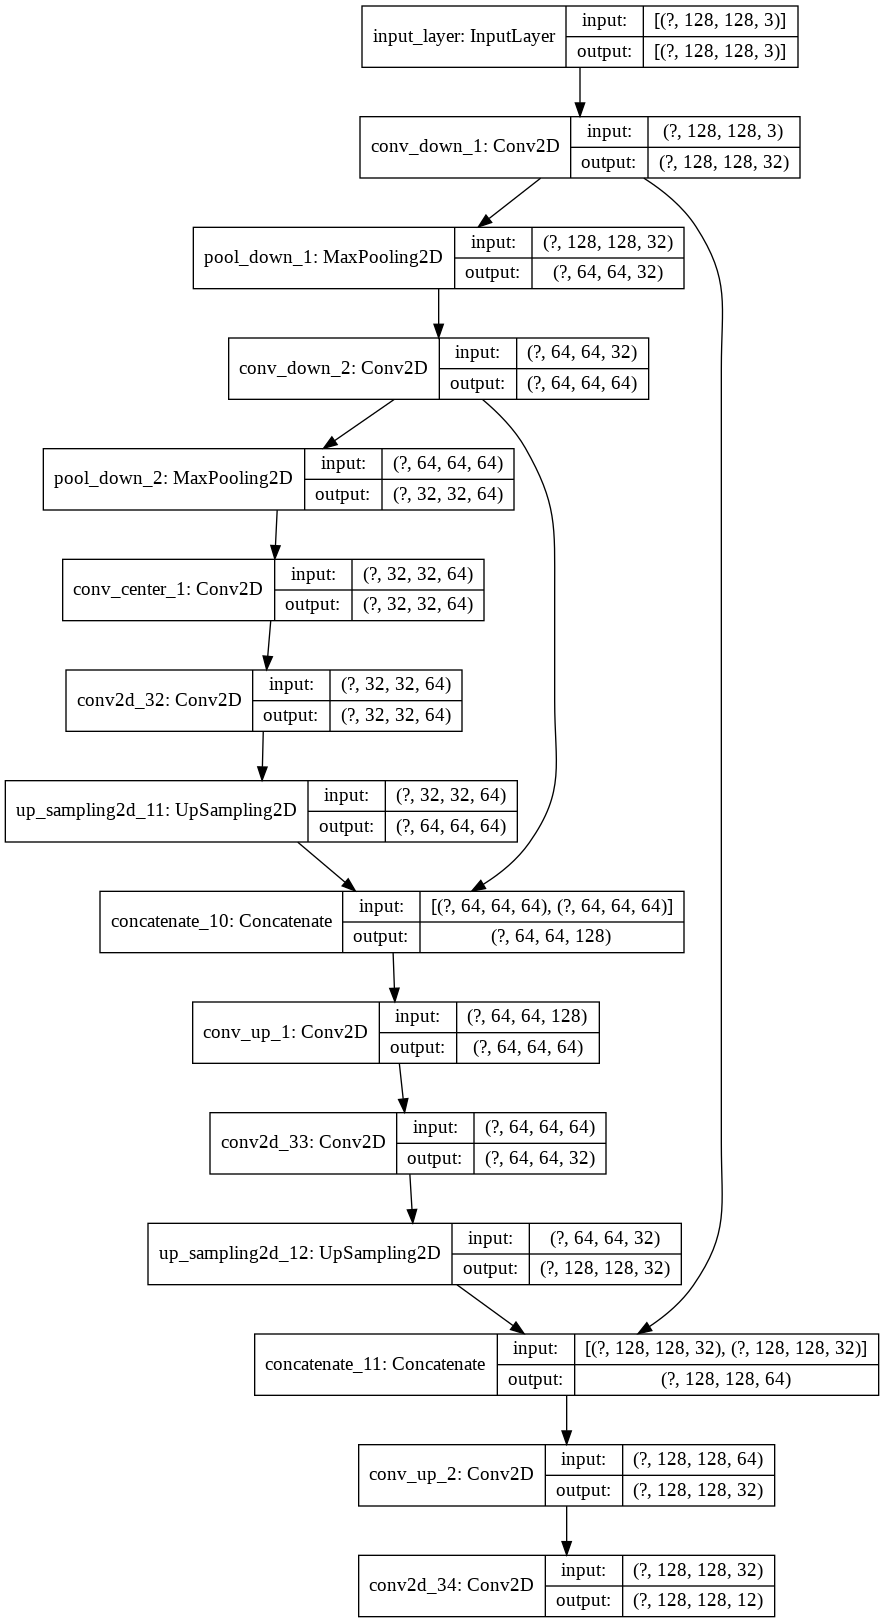

In [ ]:

HG,_ = get_HourGlass(ip_dim=(128, 128, 3), end_filters=12, conv_perblock=1, center_conv=1, cblocks=2)

HG.summary()

from tensorflow.keras.utils import plot_model

plot_model(HG, show_shapes= True)

In [ ]:
# from tensorflow.keras.layers import Input, Conv2D, Dropout, BatchNormalization, Dense, MaxPooling2D, Concatenate, Cropping2D, UpSampling2D, Conv2DTranspose
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import plot_model

# def get_HourGlass(cblocks = 2 , conv_perblock = 2, dropout=0.1, batchNorm = False, ip_dim=(128,128,1),
#              center_conv=2, start_filters=32, concat = True, end_filters = 1, name = "SH"):
#     args = locals()
#     if ip_dim[0] != ip_dim[1]:
#         print("Warning: This function is tested only for images with Square shape eg. 64x64x3 or 128x128x1")
#     if 2 ** cblocks > ip_dim[1]:
#         raise ValueError("Too many CONV Blocks!")
        
#     bnorm, conv, drop, pool, deconv, upscale = [[1 for _ in range(3)] for __ in range(6)]
  
#     ipt = Input(shape = (ip_dim[0], ip_dim[1], ip_dim[2]), name = name+"input_layer")
#     temp = ipt
  
#     for i in range(cblocks):
#         for _ in range(conv_perblock):
#             if batchNorm:
#               temp = BatchNormalization(name = name+"BN_down_"+str(bnorm[0]))(temp)
#               bnorm[0]+=1
#             temp = Conv2D(kernel_size = 3, filters = start_filters * 2**i,
#                           activation = "relu", padding ="same", name = name+"conv_down_"+str(conv[0]))(temp)
#             conv[0]+=1
#             temp = Dropout(rate = dropout, name = name+"drop_down_" + str(drop[0]))(temp)
#             drop[0]+=1
    
#         temp = MaxPooling2D(pool_size =2, name = name+"pool_down_"+str(pool[0]))(temp)
#         pool[0]+=1
    

#     ##Encoder part (downsampling only) completed
    
#     tempModel = Model(inputs =[ipt], outputs = [temp])
#     for i in range(center_conv):
#         if batchNorm:
#           temp = BatchNormalization(name = name+"BN_center_"+str(bnorm[1]))(temp)
#           bnorm[1]+=1
#         temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-1),
#                       activation = "relu", padding ="same", name = name+"conv_center_"+str(conv[1]))(temp)
#         conv[1]+=1
#         temp = Dropout(rate = dropout, name = name+"drop_center_" + str(drop[1]))(temp)
#         drop[1]+=1
#     #plot_model(tempModel, to_file = "halfUnet.png", show_shapes=True)
#     #tempModel.summary()
#     for i in range(cblocks):
#         #temp = UpSampling2D(size =2, name = "pool_"+str(upscale))(temp)
#         #upscale+=1
#         #temp = Conv2DTranspose(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
#         #strides = (2,2), padding = "same", activation ="relu")(temp)
#         #print(i)

#         if concat:
#             temp = Conv2D(kernel_size = (3,3), filters = start_filters * 2**(cblocks-i-1),
#                           padding = "same", activation ="relu")(temp)
#         temp = UpSampling2D(size = (2,2), interpolation = "bilinear")(temp)
#         if concat:
#             temp1 = tempModel.get_layer(name = name+"drop_down_"+str(drop[0] - conv_perblock*i-1)).output
#             temp = Concatenate(axis = -1)([temp, temp1])

#         for _ in range(conv_perblock):
#             if batchNorm:
#               temp = BatchNormalization(name = name+"BN_up_"+str(bnorm[2]))(temp)
#               bnorm[2]+=1
#             temp = Conv2D(kernel_size = 3, filters = start_filters * 2**(cblocks-i-1),
#                           activation = "relu", padding ="same", name = "conv_up_"+str(conv[2]))(temp)
#             conv[2]+=1
#             temp = Dropout(rate = dropout, name = name+"drop_up_" + str(drop[2]))(temp)
#             drop[2]+=1
#         #xtemp =Model(inputs = [ipt], outputs = [temp])
#         #plot_model(xtemp, to_file = "xUnet.png", show_shapes=True)

#     temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
#     temp = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "relu", padding = "same")(temp)  
#     opt = Conv2D(kernel_size=(1,1), filters = end_filters, activation = "softmax", padding = "same")(temp)  

#     return Model(inputs = [ipt], outputs = [opt], name = name), args

In [ ]:
def getStackedSHM( ip_dim = (IMAGE_SIZE, IMAGE_SIZE, 3), start_filters=16, body_keypoints=3, cblocks=2, conv_perblock=2):
  
  first_hg,args = get_HourGlass(ip_dim = ip_dim, start_filters=start_filters, end_filters=body_keypoints, cblocks=cblocks, conv_perblock=conv_perblock, name = "SH-1")
  second_hg,args = get_HourGlass(ip_dim = (ip_dim[0], ip_dim[1], ip_dim[2] + body_keypoints), start_filters=start_filters, end_filters=body_keypoints, cblocks=cblocks, conv_perblock=conv_perblock, name = "SH-2")
  third_hg,args = get_HourGlass(ip_dim = (ip_dim[0],  ip_dim[1], ip_dim[2] + body_keypoints), start_filters=start_filters, end_filters=body_keypoints, cblocks=cblocks, conv_perblock=conv_perblock, name = "SH-3")


  image = Input(shape = (ip_dim[0], ip_dim[1], ip_dim[2]))

  first_heatmaps = first_hg(image)
  second_inputs = Concatenate(axis=-1)([image, first_heatmaps])
  second_heatmaps = second_hg(second_inputs)
  third_inputs = Concatenate(axis=-1)([image, second_heatmaps])
  third_heatmaps = third_hg(third_inputs)
  

  model = Model(inputs = [image], outputs = [first_heatmaps, second_heatmaps, third_heatmaps])
  return model


In [ ]:
SHM = getStackedSHM(ip_dim=(IMAGE_SIZE, IMAGE_SIZE, 3), body_keypoints = 13, start_filters=16, cblocks=2, conv_perblock=2)


SHM.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
SH-1 (Functional)               (None, 128, 128, 13) 84265       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_6 (Concatenate)     (None, 128, 128, 16) 0           input_1[0][0]                    
                                                                 SH-1[0][0]                       
__________________________________________________________________________________________________
SH-2 (Functional)               (None, 128, 128, 13) 86137       concatenate_6[0][0]        

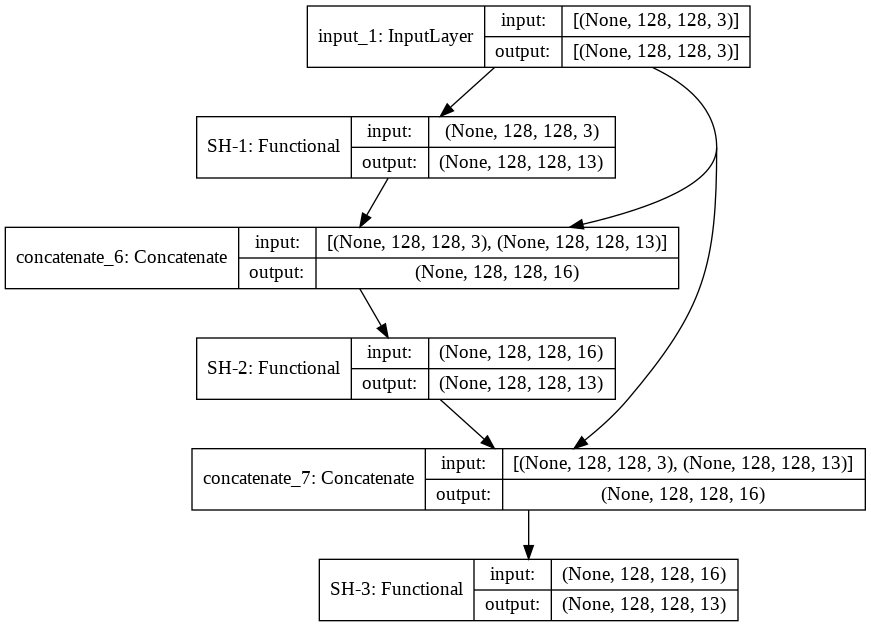

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(SHM, show_shapes= True)

In [ ]:
import tensorflow as tf

# custom weighted loss function (weighted categorical cross entropy)
def weighted_crossentropy(y_true, y_pred):
  EPSILON = 0.0001

  y_t = tf.math.multiply(tf.broadcast_to(tf.constant([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5], dtype = float), tf.shape(y_true)) , y_true)
  h_t = tf.math.multiply(tf.broadcast_to(tf.constant([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5], dtype = float), tf.shape(y_pred)) , y_pred)

  return tf.math.reduce_mean(- tf.math.multiply(y_t  , tf.math.log(tf.add(h_t, EPSILON))))

In [ ]:
from tensorflow.keras.callbacks import *

callbacks = [
             EarlyStopping(monitor= "val_loss", patience = 25, restore_best_weights= True),
             ReduceLROnPlateau(monitor="val_loss", patience=10)
]

In [ ]:
SHM.compile(optimizer= "adam", loss = [weighted_crossentropy, weighted_crossentropy,weighted_crossentropy], loss_weights=[0.5, 0.5, 1.0])
history = SHM.fit(train_images, [train_heatmaps, train_heatmaps, train_heatmaps] , epochs = 500, validation_split=0.1, callbacks=callbacks, verbose=1)

Epoch 1/500
23/23 [==============================] - 45s 372ms/step - loss: 0.2640 - SH-1_loss: 0.1349 - SH-2_loss: 0.1297 - SH-3_loss: 0.1317 - val_loss: 0.2237 - val_SH-1_loss: 0.1256 - val_SH-2_loss: 0.1043 - val_SH-3_loss: 0.1088
Epoch 2/500
23/23 [==============================] - 7s 285ms/step - loss: 0.2094 - SH-1_loss: 0.1233 - SH-2_loss: 0.0946 - SH-3_loss: 0.1004 - val_loss: 0.1835 - val_SH-1_loss: 0.1083 - val_SH-2_loss: 0.0857 - val_SH-3_loss: 0.0865
Epoch 3/500
23/23 [==============================] - 7s 284ms/step - loss: 0.1852 - SH-1_loss: 0.1082 - SH-2_loss: 0.0862 - SH-3_loss: 0.0880 - val_loss: 0.1587 - val_SH-1_loss: 0.0901 - val_SH-2_loss: 0.0770 - val_SH-3_loss: 0.0751
Epoch 4/500
23/23 [==============================] - 7s 285ms/step - loss: 0.1579 - SH-1_loss: 0.0855 - SH-2_loss: 0.0760 - SH-3_loss: 0.0771 - val_loss: 0.1506 - val_SH-1_loss: 0.0732 - val_SH-2_loss: 0.0760 - val_SH-3_loss: 0.0760
Epoch 5/500
23/23 [==============================] - 7s 286ms/step 

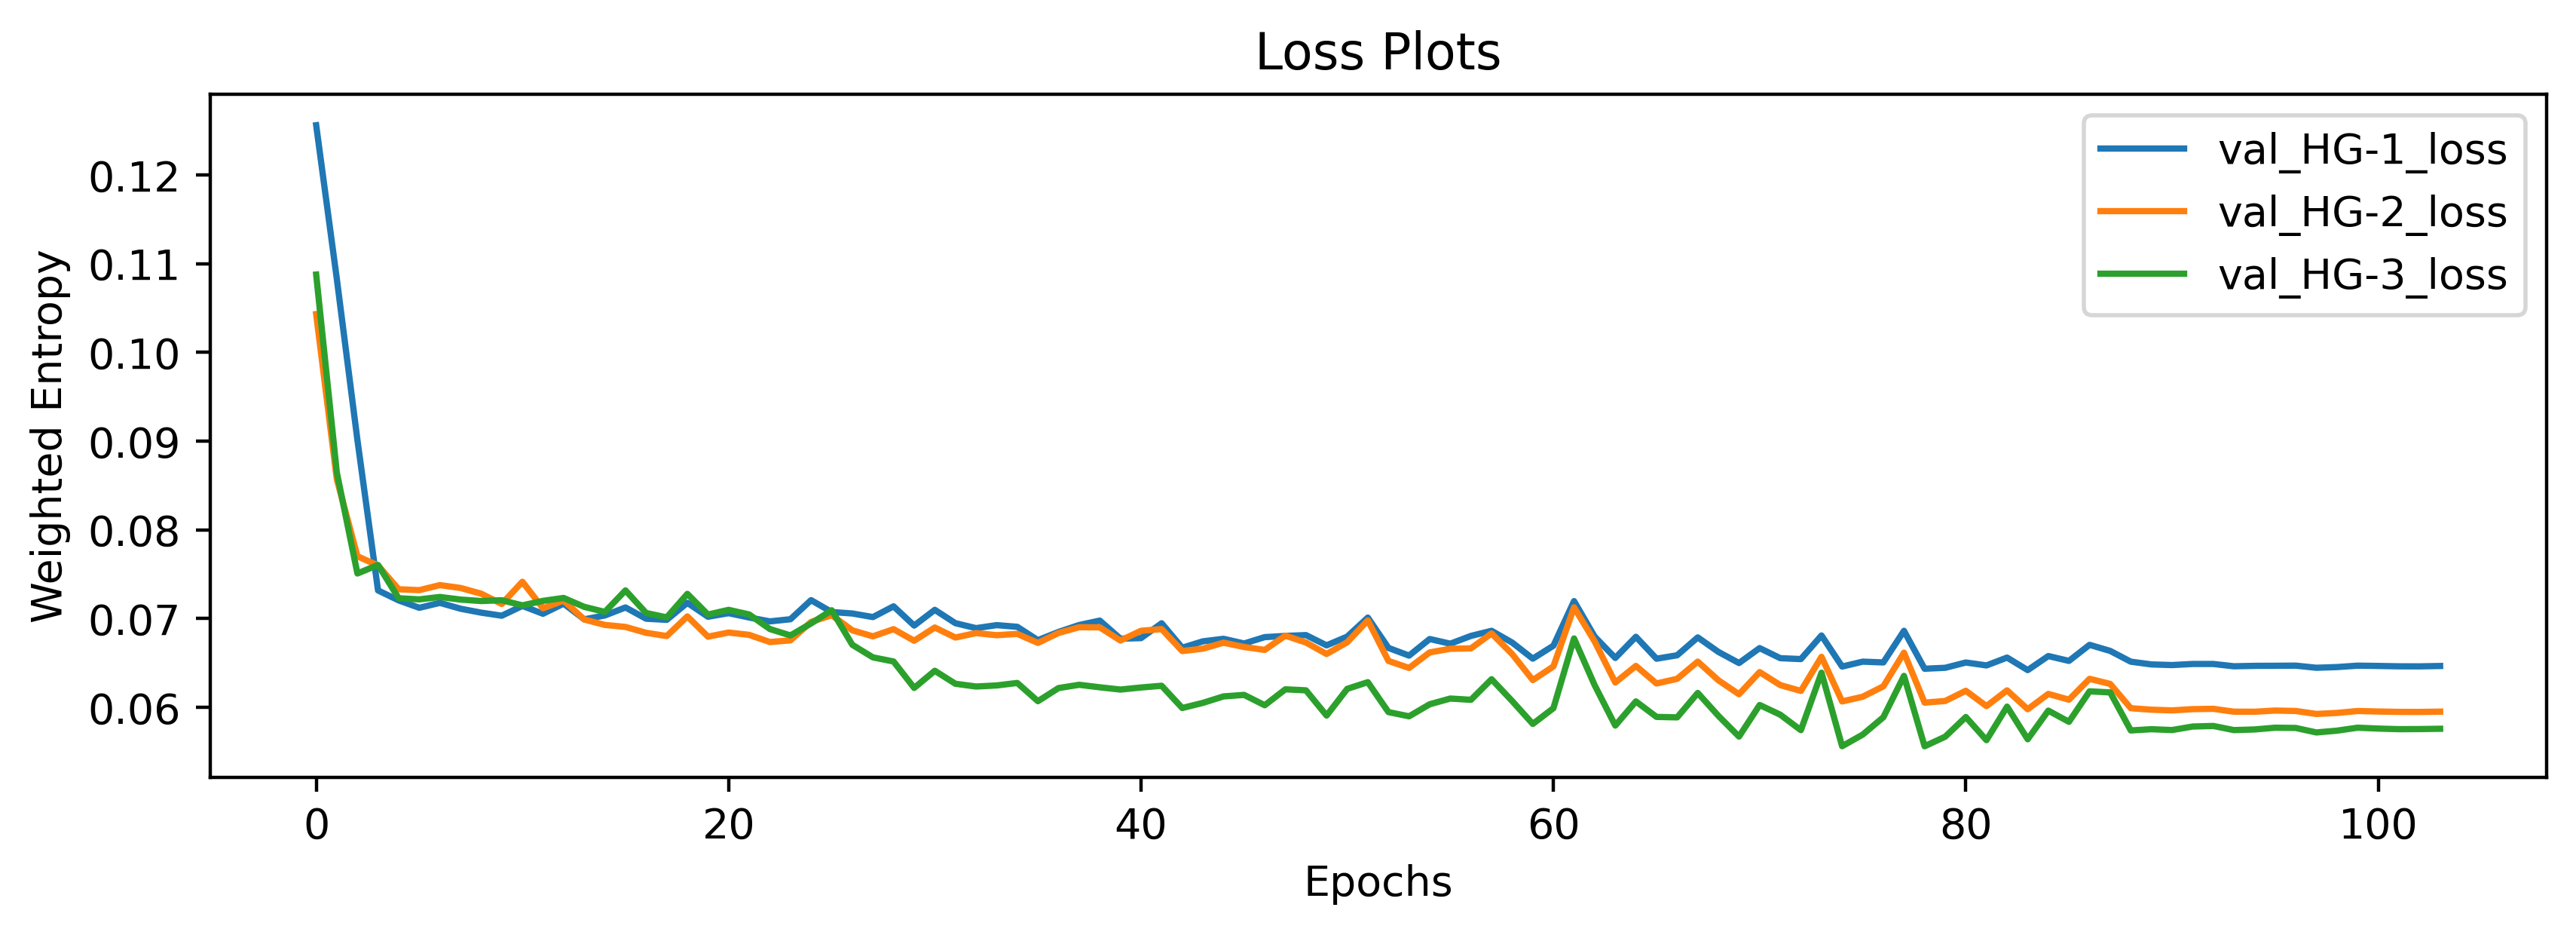

In [ ]:
# Defining a function for plotting training and validation learning curves
def plot_history(history):
	  # plot loss
    plt.figure(figsize=(10, 3), dpi = 400)
    plt.title('Loss Plots')

    # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_SH-1_loss'], label='val_HG-1_loss')
    plt.plot(history.history['val_SH-2_loss'], label='val_HG-2_loss')
    plt.plot(history.history['val_SH-3_loss'], label='val_HG-3_loss')
    
    plt.ylabel('Weighted Entropy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    # # plot accuracy
    # plt.title('Accuracy')
    # plt.plot(history.history['accuracy'], color='blue', label='train')
    # plt.plot(history.history['val_accuracy'], color='red', label='test')
    # plt.ylabel('Accuracy')
    # plt.xlabel('Epoch')
    # plt.legend(['Train', 'Validation'])
    # plt.show()
  
plot_history(history)

(100, 128, 128, 13)
(100, 128, 128, 13)


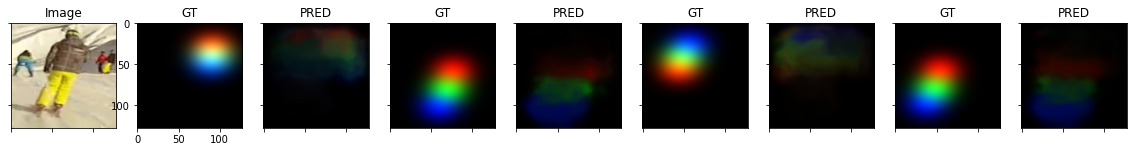

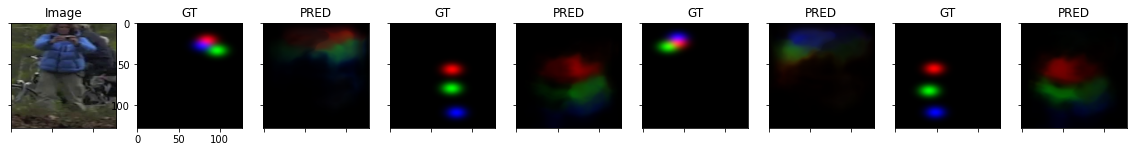

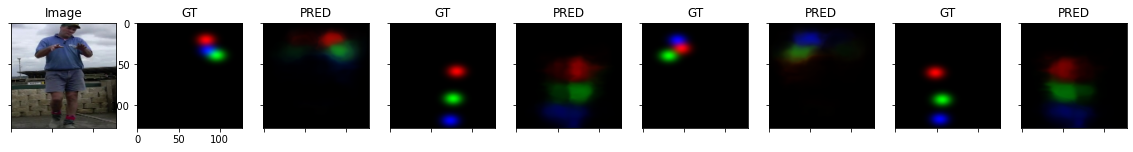

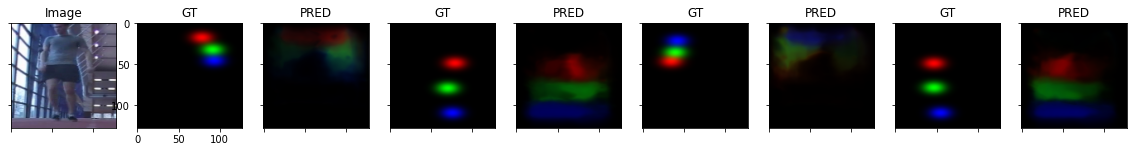

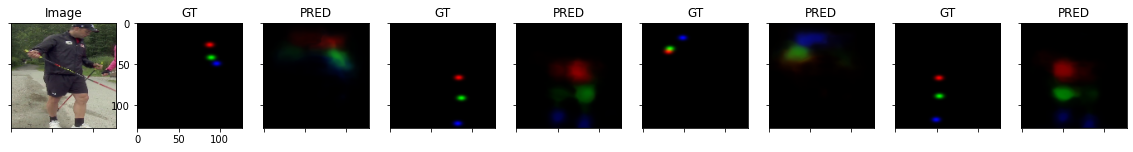

In [8]:
NUMBER_SAMPLES = 5
NUMBER_PREDS = 100
pred_heatmaps = SHM.predict(train_images[:NUMBER_PREDS])[-1]
gt_heatmaps = train_heatmaps[:NUMBER_PREDS]

print(pred_heatmaps.shape)
print(gt_heatmaps.shape)

imgs = train_images[:NUMBER_PREDS]


for i in range(NUMBER_SAMPLES):
  plt.figure(figsize=(20,5))

  indx = random.randint(0, imgs.shape[0]-1)
  indx = i

  ax= plt.subplot(1, 9, 1)  
  ax.set_title("Image")
  ax.set_xticklabels([])
  ax.set_yticklabels([])


  rgb_img_for_display = cv2.cvtColor((255*imgs[indx]).astype(np.uint8), cv2.COLOR_BGR2RGB)
  ax.imshow(rgb_img_for_display)

  ax= plt.subplot(1, 9, 2)  
  ax.set_title("GT")
  # ax.set_xticklabels([])
  # ax.set_yticklabels([])
  
  ax.imshow(cv2.cvtColor((gt_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

  ax= plt.subplot(1, 9, 3)  
  ax.set_title("PRED")
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # temp = pred_heatmaps[indx] 
  # rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
  
  ax.imshow(cv2.cvtColor((pred_heatmaps[indx, ..., :3]*255).astype(np.uint8), cv2.COLOR_BGR2RGB))

  ax= plt.subplot(1, 9, 4)  
  ax.set_title("GT")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((gt_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

  ax= plt.subplot(1, 9, 5)  
  ax.set_title("PRED")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((pred_heatmaps[indx, ..., 3:6]*255).astype(np.uint8))

  ax= plt.subplot(1, 9, 6)  
  ax.set_title("GT")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((gt_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

  ax= plt.subplot(1, 9, 7)  
  ax.set_title("PRED")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((pred_heatmaps[indx, ..., 6:9]*255).astype(np.uint8))

  ax= plt.subplot(1, 9, 8)  
  ax.set_title("GT")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((gt_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

  ax= plt.subplot(1, 9, 9)  
  ax.set_title("PRED")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((pred_heatmaps[indx, ..., 9:12]*255).astype(np.uint8))

  plt.show()




In [18]:
NUMBER_SAMPLES = 20
NUMBER_PREDS = 100
pred_heatmaps = SHM.predict(train_images[:NUMBER_PREDS])
gt_heatmaps = train_heatmaps[:NUMBER_PREDS]

# print(pred_heatmaps.shape)
print(gt_heatmaps.shape)

imgs = train_images[:NUMBER_PREDS]


for i in range(NUMBER_SAMPLES):
  plt.figure(figsize=(20,5))

  indx = random.randint(0, imgs.shape[0]-1)
  indx = i

  ax= plt.subplot(1, 5, 1)  
  ax.set_title("Image")
  ax.set_xticklabels([])
  ax.set_yticklabels([])


  rgb_img_for_display = cv2.cvtColor((255*imgs[indx]).astype(np.uint8), cv2.COLOR_BGR2RGB)
  ax.imshow(rgb_img_for_display)

  ax= plt.subplot(1, 5, 2)  
  ax.set_title("GT")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  
  ax.imshow((gt_heatmaps[indx, ..., :3]*255).astype(np.uint8))

  ax= plt.subplot(1, 5, 3)  
  ax.set_title("PRED SH -1")
  ax.set_xticklabels([])
  ax.set_yticklabels([])

  # temp = pred_heatmaps[indx] 
  # rgb_img_for_display = cv2.cvtColor((255*temp).astype(np.uint8), cv2.COLOR_BGR2RGB)
  
  ax.imshow((pred_heatmaps[0][indx, ..., :3]*255).astype(np.uint8))

  ax= plt.subplot(1, 5, 4)  
  ax.set_title("PRED SH-2")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((pred_heatmaps[1][indx, ..., :3]*255).astype(np.uint8))

  ax= plt.subplot(1, 5, 5)  
  ax.set_title("PRED SH-3")
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow((pred_heatmaps[2][indx, ..., :3]*255).astype(np.uint8))

  plt.show()




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
SHM.evaluate(train_images, [train_heatmaps, train_heatmaps, train_heatmaps])
SHM.evaluate(test_images, [test_heatmaps, test_heatmaps, test_heatmaps])


7/7 [==============================] - 1s 107ms/step - loss: 0.1181 - SH-1_loss: 0.0645 - SH-2_loss: 0.0599 - SH-3_loss: 0.0559


[0.11809752136468887,
 0.06451661139726639,
 0.05994321033358574,
 0.05586762726306915]

In [ ]:
from tensorflow.keras.models import save_model

save_model(SHM, os.path.join("/content/drive/Shareddrives/DLNN_ProjF/data/model", "SHM_3_unaugmented_data_best.h5"))

NameError: ignored

In [22]:
def euclidean(a,b):
  return(np.sqrt(np.sum((a-b)** 2)))


x = range(0, IMAGE_SIZE)
y = range(0, IMAGE_SIZE)
(X,Y) = np.meshgrid(x,y)

trues = np.array([0 for i in range(12)])
falses = np.array([0 for i in range(12)])

for i in range(NUMBER_PREDS):
  for channel in range(NUM_CLASSES):
    # getting GT-coords
    img = train_heatmaps[i, ..., channel]
    gt_x_coord = (X*img).sum() / img.sum().astype("float")
    gt_y_coord = (Y*img).sum() / img.sum().astype("float")

    # getting PRED-coords
    img = pred_heatmaps[-1][i, ..., channel]
    pred_x_coord = (X*img).sum() / img.sum().astype("float")
    pred_y_coord = (Y*img).sum() / img.sum().astype("float")

    distance = euclidean(np.array([pred_x_coord, pred_y_coord]), np.array([gt_x_coord, gt_y_coord]))

    if distance < train_headlengths[i]*4:
      trues[channel] +=1
    else:
      falses[channel] += 1

In [23]:
print(trues, falses)

[64 77 86 93 92 78 62 80 88 97 86 76] [36 23 14  7  8 22 38 20 12  3 14 24]


In [24]:
trues / (trues + falses)

array([0.64, 0.77, 0.86, 0.93, 0.92, 0.78, 0.62, 0.8 , 0.88, 0.97, 0.86,
       0.76])

In [7]:
from tensorflow.keras.models import load_model

SHM = load_model(os.path.join("/content/drive/Shareddrives/DLNN_ProjF/data/model", "SHM_3_unaugmented_data_best.h5"), compile = False)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
x = range(0, IMAGE_SIZE)
y = range(0, IMAGE_SIZE)
(X,Y) = np.meshgrid(x,y)


NUMBER_PREDS = 100


pred_heatmaps = SHM.predict(test_images[:NUMBER_PREDS])[-1]
gt_heatmaps = test_heatmaps[:NUMBER_PREDS]

print(pred_heatmaps.shape)
print(gt_heatmaps.shape)

imgs = test_images[:NUMBER_PREDS]


# sample images
cols = 10
rows = 10
np.random.seed(33)

row_images = []

for i in range(rows):
  indices = np.random.rand(cols)
  indices = (indices*NUMBER_PREDS).astype(np.int64)  

  row = test_images[indices[0], ...]
  for j in range(1, cols):
    temp = test_images[indices[j]]

    x_coords = []
    y_coords = []
    for channel in range(NUM_CLASSES):
      # getting GT-coords
      img = pred_heatmaps[indices[j], ..., channel]
      gt_x_coord = (X*img).sum() / img.sum().astype("float")
      gt_y_coord = (Y*img).sum() / img.sum().astype("float")

      # getting PRED-coords
      img = pred_heatmaps[indices[j], ..., channel]
      pred_x_coord = (X*img).sum() / img.sum().astype("float")
      pred_y_coord = (Y*img).sum() / img.sum().astype("float")

      x_coord = int((gt_x_coord + pred_x_coord) / 2)
      y_coord = int((gt_y_coord + pred_y_coord) / 2)

      x_coords.append(x_coord)
      y_coords.append(y_coord)
      # temp = cv2.circle(temp, (x_coord, y_coord), 3, (0, 1, 1), -1)

    temp = cv2.line(temp, (x_coords[0], y_coords[0]), (x_coords[1], y_coords[1]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[1], y_coords[1]), (x_coords[2], y_coords[2]), (1, 0, 0), 2)

    temp = cv2.line(temp, (x_coords[3], y_coords[3]), (x_coords[4], y_coords[4]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[4], y_coords[4]), (x_coords[5], y_coords[5]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[6], y_coords[6]), (x_coords[7], y_coords[7]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[7], y_coords[7]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    

    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[10], y_coords[10]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[10], y_coords[10]), (x_coords[11], y_coords[11]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[3], y_coords[3]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[2], y_coords[2]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    
    temp = cv2.line(temp, (x_coords[2], y_coords[2]), (x_coords[3], y_coords[3]), (1, 0, 0), 2)
    temp = cv2.line(temp, (x_coords[9], y_coords[9]), (x_coords[8], y_coords[8]), (1, 0, 0), 2)
    
    for channel in range(NUM_CLASSES):
        temp = cv2.circle(temp, (x_coords[channel], y_coords[channel]), 3, (0, 1, 1), -1)


    row = np.hstack((row, test_images[indices[j]]))
  
  row_images.append(row[:])

image = row_images[0]
for i in range(1, rows):
  image = np.vstack((image, row_images[i]))


plt.figure(figsize=(cols*3, rows*3))
plt.imshow(cv2.cvtColor((image*255).astype(np.uint8), cv2.COLOR_BGR2RGB))




Output hidden; open in https://colab.research.google.com to view.